In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annotations[idx])

        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for member in root.findall("object"):
            
            #xmin = int(member.find("bndbox/xmin").text)
            #ymin = int(member.find("bndbox/ymin").text)
            #xmax = int(member.find("bndbox/xmax").text)
            #ymax = int(member.find("bndbox/ymax").text)

            xmin = int(float(member.find("bndbox/xmin").text))
            ymin = int(float(member.find("bndbox/ymin").text))
            xmax = int(float(member.find("bndbox/xmax").text))
            ymax = int(float(member.find("bndbox/ymax").text))
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assume all objects have the same label

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [2]:
transform = ToTensor()


In [3]:
dataset = CustomDataset(r'\... Path to the folder containing the image and annotation folders ...', transforms=transform)
#data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_model(num_classes):

    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = get_model(num_classes=2)  

In [ ]:
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10  
print_every = 5  

for epoch in range(10):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    
    for i, (images, targets) in enumerate(data_loader, 1):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        
        if i % print_every == 0:
            avg_loss = running_loss / print_every
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')
            running_loss = 0.0



In [10]:
# torch.save(model, 'Faster_RCNN.pt')

In [35]:
model = torch.load('Faster_RCNN.pt')

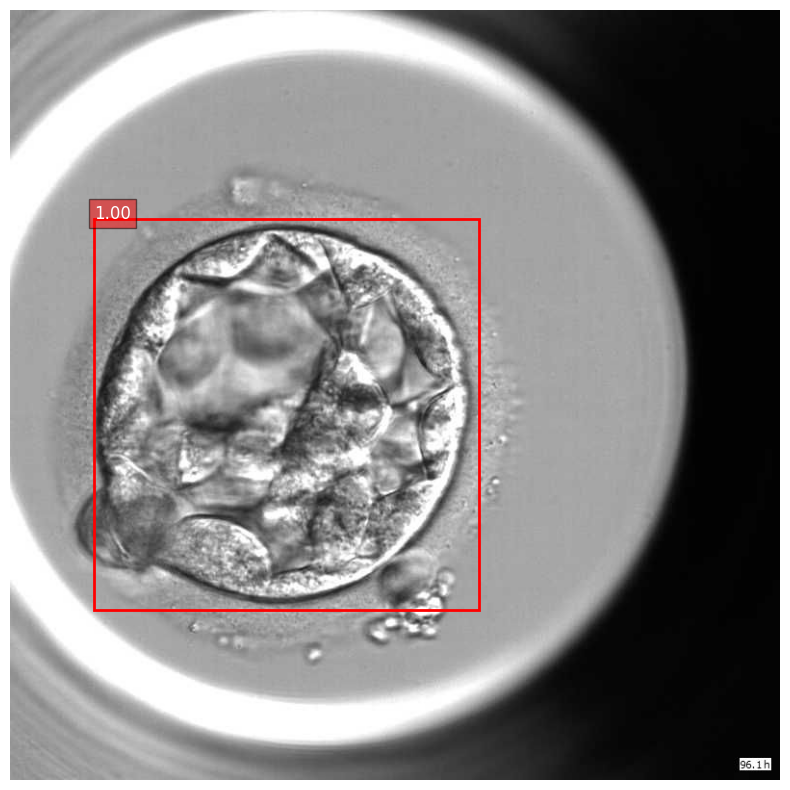

In [37]:
ImgPath = r'\ ... path to a sample image ...\ ... Image1.jpeg'
model = model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

display_prediction(ImgPath, model, device)

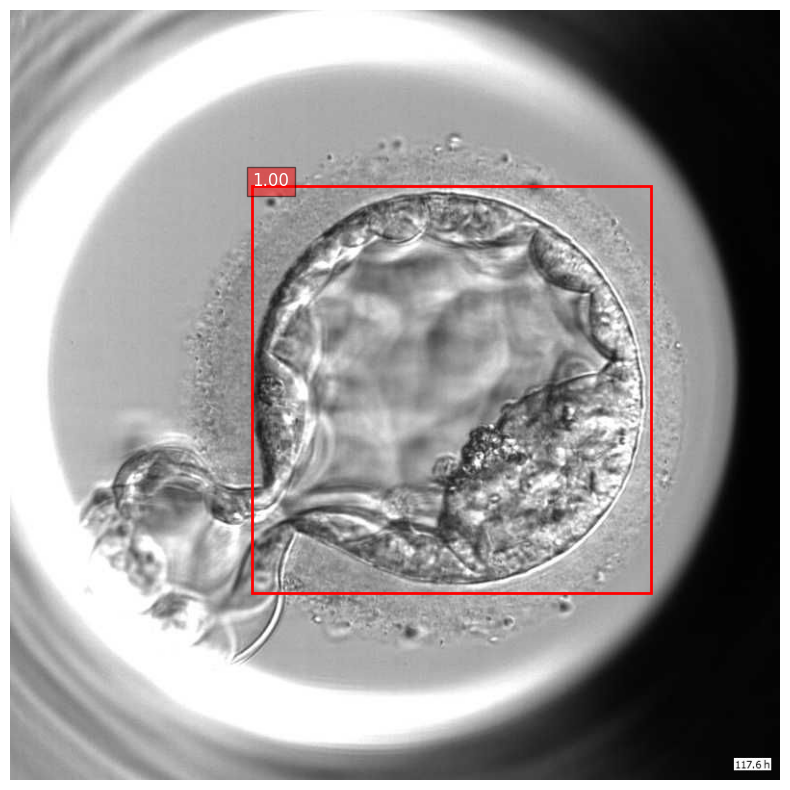

In [44]:
ImgPath = r'\ ... path to a another example image ...\ ... Image2.jpeg'
model = model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

display_prediction(ImgPath, model, device)

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_prediction(image_path, model, device, threshold=0.5):
    
    image = Image.open(image_path).convert("RGB")
    transform = ToTensor()  # Assuming ToTensor transform is what was used during training
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(image))
    ax = plt.gca()
    
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    
    for box, score in zip(pred_boxes, pred_scores):
        if score > threshold:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f"{score:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.axis('off')  
    plt.show()